In [1]:


# Install required libraries
!pip install tensorflow numpy pandas matplotlib scikit-learn pyswarm seaborn -q

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Layer, SimpleRNN
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from pyswarm import pso
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Step 1: Generate Synthetic PV Power Dataset ---
def generate_synthetic_pv_data(n_samples=500):
    time = np.arange(n_samples)
    solar_irradiance = 1000 * np.sin(2 * np.pi * time / 24) + np.random.normal(0, 50, n_samples)
    temperature = 25 + 5 * np.sin(2 * np.pi * time / 24) + np.random.normal(0, 2, n_samples)
    pv_power = solar_irradiance * 0.15 * (1 - 0.005 * (temperature - 25)) + np.random.normal(0, 10, n_samples)
    pv_power = np.clip(pv_power, 0, None)
    return pd.DataFrame({'solar_irradiance': solar_irradiance, 'temperature': temperature, 'pv_power': pv_power})

data = generate_synthetic_pv_data()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['solar_irradiance', 'temperature', 'pv_power']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

  Preparing metadata (setup.py) ... done


In [2]:
# Split data
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Flatten X for simple metaheuristic models (PSO, GA, CPO, Simple Attention)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [3]:
# --- Step 2: Define Simple Attention Layer ---
class SimpleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(SimpleAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=1)

In [4]:
# --- Step 3: Define Baseline Models ---
def build_rnn():
    model = Sequential([SimpleRNN(64, input_shape=(seq_length, 2), return_sequences=False), Dense(1)])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_gru():
    model = Sequential([GRU(64, input_shape=(seq_length, 2), return_sequences=False), Dense(1)])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [5]:
# --- Step 4: Define Simple Metaheuristic-Optimized Models ---
def build_simple_model_for_opt(params):
    units, lr = int(params[0]), params[1]
    model = Sequential([Dense(units, input_shape=(seq_length * 2,), activation='relu'), Dense(1)])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def objective_function_meta(params):
    model = build_simple_model_for_opt(params)
    model.fit(X_train_flat, y_train, epochs=10, batch_size=32, verbose=0)
    return model.evaluate(X_val_flat, y_val, verbose=0)

# PSO
lb = [32, 0.0001]
ub = [128, 0.01]
best_params_pso, _ = pso(objective_function_meta, lb, ub, swarmsize=10, maxiter=10)

# GA
def ga_optimize(pop_size=10, generations=10):
    population = [np.random.uniform(lb, ub, 2) for _ in range(pop_size)]
    for _ in range(generations):
        fitness = [objective_function_meta(ind) for ind in population]
        best_idx = np.argmin(fitness)
        best = population[best_idx]
        population = [best if random.random() < 0.2 else np.random.uniform(lb, ub, 2) for _ in range(pop_size)]
    return best

best_params_ga = ga_optimize()

# CPO
def cpo_optimize_simple(n_porcupines=12, max_iter=15):
    lb = [32, 0.0001]
    ub = [128, 0.01]
    population = np.random.uniform(lb, ub, (n_porcupines, 2))
    best_solution = None
    best_fitness = float('inf')

    for _ in range(max_iter):
        for i in range(n_porcupines):
            params = population[i]
            val_loss = objective_function_meta(params)
            if val_loss < best_fitness:
                best_fitness = val_loss
                best_solution = params.copy()

        for i in range(n_porcupines):
            if random.random() < 0.5:
                population[i] = np.random.uniform(lb, ub, 2)
            else:
                population[i] = best_solution + np.random.normal(0, 0.1, 2)
                population[i] = np.clip(population[i], lb, ub)

    return best_solution

best_params_cpo_simple = cpo_optimize_simple()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopping search: maximum iterations reached --> 10


In [6]:
# --- Step 5: Define Enhanced CPO-GRU-Attention ---
def build_cpo_gru_attention(params):
    gru1_units, gru2_units, lr, dropout_rate = int(params[0]), int(params[1]), params[2], params[3]
    model = Sequential([
        GRU(gru1_units, input_shape=(seq_length, 2), return_sequences=True),
        Dropout(dropout_rate),
        GRU(gru2_units, return_sequences=True),
        SimpleAttentionLayer(),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def objective_function_cpo_gru(params):
    model = build_cpo_gru_attention(params)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    return model.evaluate(X_val, y_val, verbose=0)

def cpo_optimize_gru(n_porcupines=12, max_iter=15):
    lb = [32, 32, 0.0001, 0.1]
    ub = [128, 128, 0.01, 0.4]
    population = np.random.uniform(lb, ub, (n_porcupines, 4))
    best_solution = None
    best_fitness = float('inf')

    for _ in range(max_iter):
        for i in range(n_porcupines):
            params = population[i]
            val_loss = objective_function_cpo_gru(params)
            if val_loss < best_fitness:
                best_fitness = val_loss
                best_solution = params.copy()

        for i in range(n_porcupines):
            if random.random() < 0.5:
                population[i] = np.random.uniform(lb, ub, 4)
            else:
                population[i] = best_solution + np.random.normal(0, 0.1, 4)
                population[i] = np.clip(population[i], lb, ub)

    return best_solution

best_params_cpo_gru = cpo_optimize_gru()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# --- Step 6: Define New Models ---
# Simple Attention Model
def build_simple_attention():
    model = Sequential([
        Dense(64, input_shape=(seq_length * 2,), activation='relu'),
        SimpleAttentionLayer(),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# PSO-GRU Model
def build_gru_for_pso(params):
    units, lr = int(params[0]), params[1]
    model = Sequential([GRU(units, input_shape=(seq_length, 2), return_sequences=False), Dense(1)])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def objective_function_pso_gru(params):
    model = build_gru_for_pso(params)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    return model.evaluate(X_val, y_val, verbose=0)

lb_gru = [32, 0.0001]
ub_gru = [128, 0.01]
best_params_pso_gru, _ = pso(objective_function_pso_gru, lb_gru, ub_gru, swarmsize=10, maxiter=10)

def build_pso_gru():
    units, lr = int(best_params_pso_gru[0]), best_params_pso_gru[1]
    model = Sequential([GRU(units, input_shape=(seq_length, 2), return_sequences=False), Dense(1)])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

Stopping search: maximum iterations reached --> 10


In [13]:
# --- Step 7: Train All Models ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Import Reshape layer
from tensorflow.keras.layers import Reshape

# Define models, overriding 'Simple Attention' to include Reshape
models = {
    'RNN': build_rnn(),
    'GRU': build_gru(),
    'PSO': build_simple_model_for_opt(best_params_pso),
    'GA': build_simple_model_for_opt(best_params_ga),
    'CPO': build_simple_model_for_opt(best_params_cpo_simple),
    # 'Simple Attention': Sequential([
    #     Reshape((seq_length, 2), input_shape=(seq_length * 2,)),
    #     SimpleAttentionLayer(),
    #     Dense(1)
    # ]),
    'PSO-GRU': build_pso_gru(),
    'Enhanced CPO-GRU-Attention': build_cpo_gru_attention(best_params_cpo_gru)
}

# # Compile the redefined Simple Attention model
# models['Simple Attention'].compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    if name in ['RNN', 'GRU', 'PSO-GRU']:
        epochs = 20
    elif name == 'Enhanced CPO-GRU-Attention':
        epochs = 25
    else:
        epochs = 20  # For simple metaheuristic and attention models
    if name in ['RNN', 'GRU', 'PSO-GRU', 'Enhanced CPO-GRU-Attention']:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val),
                            callbacks=[early_stopping] if name == 'Enhanced CPO-GRU-Attention' else None, verbose=0)
        y_pred = model.predict(X_test, verbose=0)
    else:  # PSO, GA, CPO, Simple Attention use flattened input
        history = model.fit(X_train_flat, y_train, epochs=epochs, batch_size=32, validation_data=(X_val_flat, y_val), verbose=0)
        y_pred = model.predict(X_test_flat, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training RNN...
Training GRU...
Training PSO...
Training GA...
Training CPO...
Training PSO-GRU...
Training Enhanced CPO-GRU-Attention...



Performance Comparison:
RNN: RMSE=0.0761, MAE=0.0573, R2=0.9476
GRU: RMSE=0.0799, MAE=0.0625, R2=0.9423
PSO: RMSE=0.0631, MAE=0.0447, R2=0.9640
GA: RMSE=0.0653, MAE=0.0470, R2=0.9614
CPO: RMSE=0.0759, MAE=0.0572, R2=0.9479
PSO-GRU: RMSE=0.0688, MAE=0.0542, R2=0.9572
Enhanced CPO-GRU-Attention: RMSE=0.0581, MAE=0.0374, R2=0.9695


<ipython-input-14-4128a8782276>:8: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



Extended Summary Table:
                                RMSE       MAE        R2  MAPE       EVS
RNN                         0.076123  0.057290  0.947582   inf -0.981155
GRU                         0.079896  0.062507  0.942257   inf -0.936094
PSO                         0.063128  0.044732  0.963951   inf -1.013108
GA                          0.065287  0.047000  0.961443   inf -0.994166
CPO                         0.075922  0.057211  0.947858   inf -0.986380
PSO-GRU                     0.068794  0.054237  0.957189   inf -0.931832
Enhanced CPO-GRU-Attention  0.058110  0.037368  0.969454   inf -1.003328


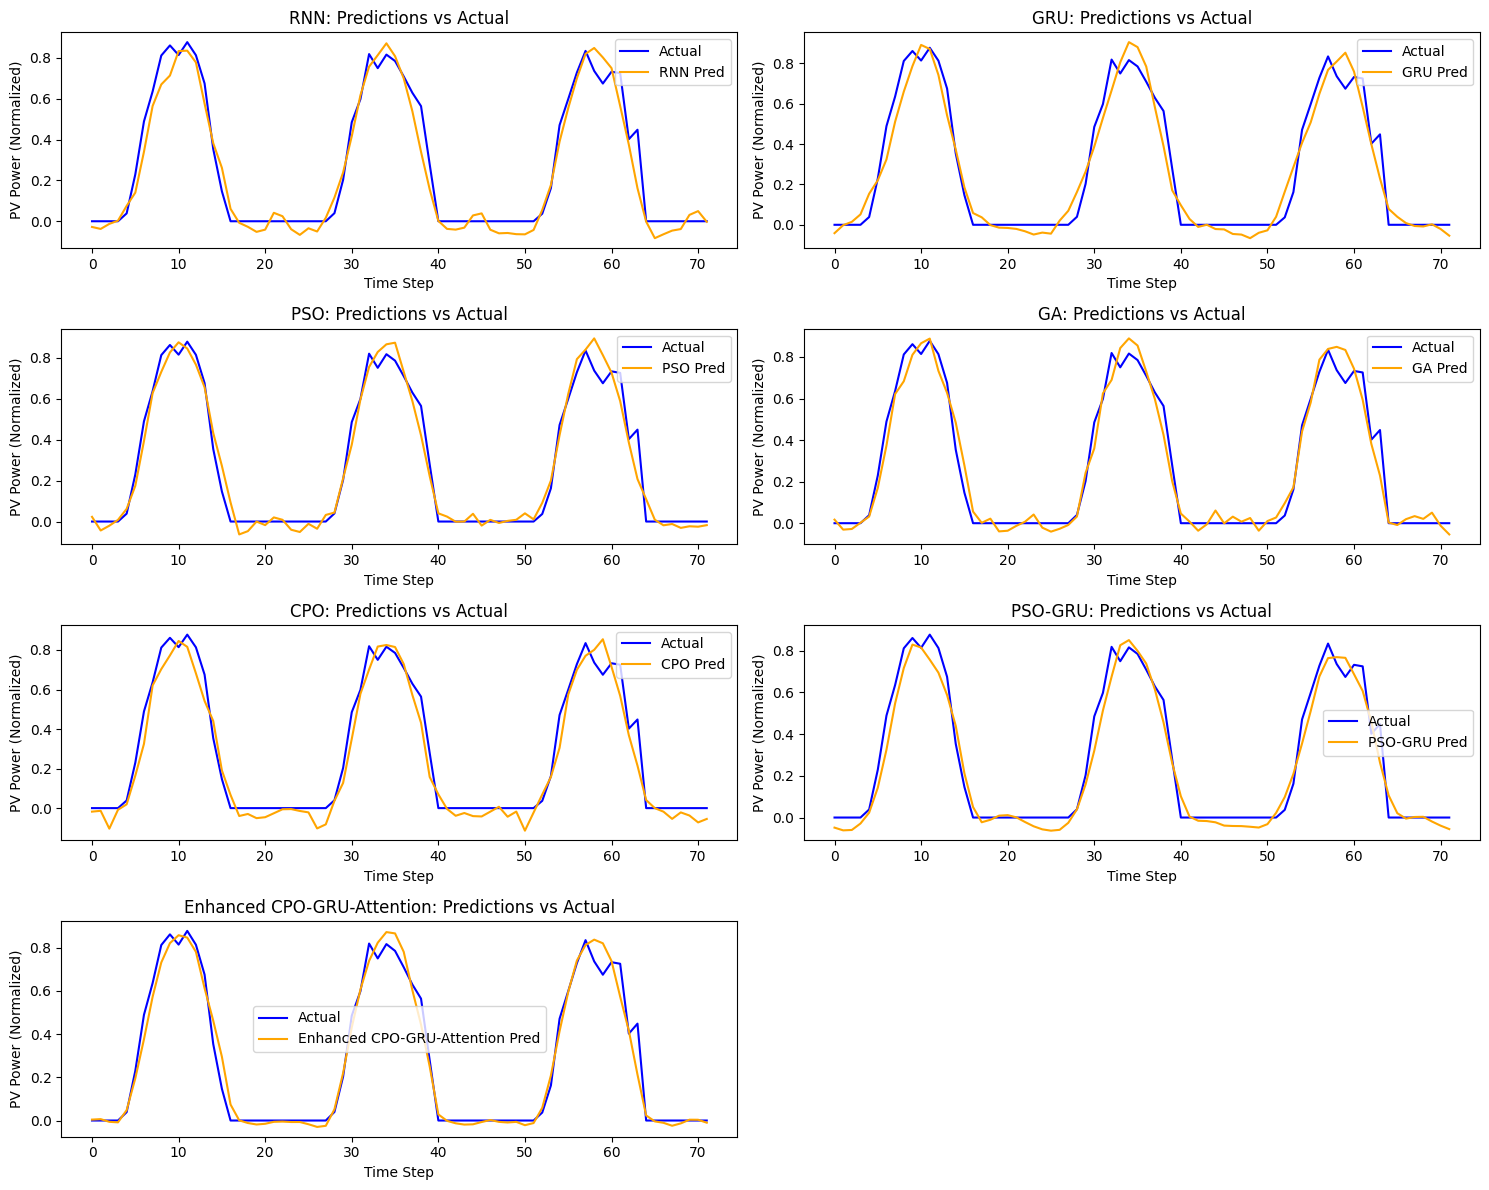

In [14]:
# --- Step 8: Evaluate and Compare ---
print("\nPerformance Comparison:")
for name, metrics in results.items():
    print(f"{name}: RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R2={metrics['R2']:.4f}")

# --- Step 9: Extended Summary Table ---
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def explained_variance_score(y_true, y_pred):
    return 1 - np.var(y_true - y_pred) / np.var(y_true)

for name, model in models.items():
    if name in ['RNN', 'GRU', 'PSO-GRU', 'Enhanced CPO-GRU-Attention']:
        y_pred = model.predict(X_test, verbose=0)
    else:
        y_pred = model.predict(X_test_flat, verbose=0)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    results[name]['MAPE'] = mape
    results[name]['EVS'] = evs

results_df = pd.DataFrame(results).T
print("\nExtended Summary Table:")
print(results_df)

# --- Step 10: Visualization ---

# 1. Prediction vs. Actual Plots
plt.figure(figsize=(15, 12))
for i, (name, metrics) in enumerate(results.items(), 1):
    plt.subplot(4, 2, i)
    if name in ['RNN', 'GRU', 'PSO-GRU', 'Enhanced CPO-GRU-Attention']:
        y_pred = models[name].predict(X_test, verbose=0)
    else:
        y_pred = models[name].predict(X_test_flat, verbose=0)
    plt.plot(y_test[:100], label='Actual', color='blue')
    plt.plot(y_pred[:100], label=f'{name} Pred', color='orange')
    plt.title(f'{name}: Predictions vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('PV Power (Normalized)')
    plt.legend()
plt.tight_layout()
plt.show()

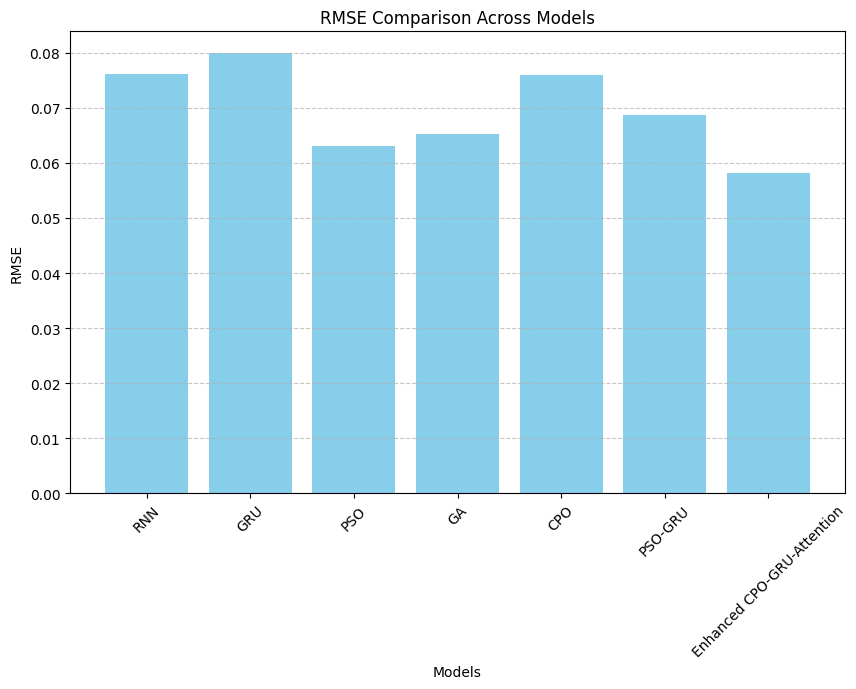

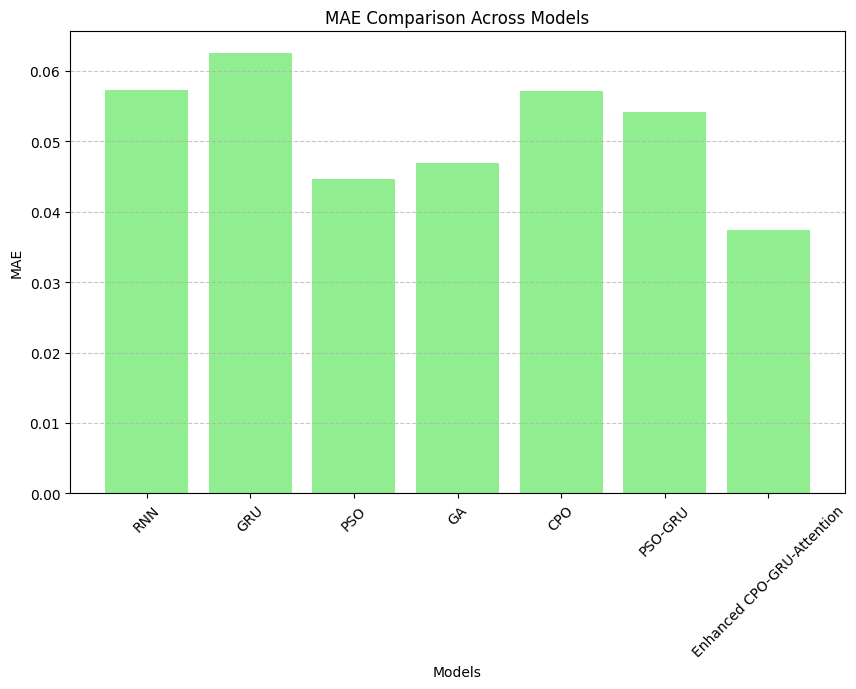

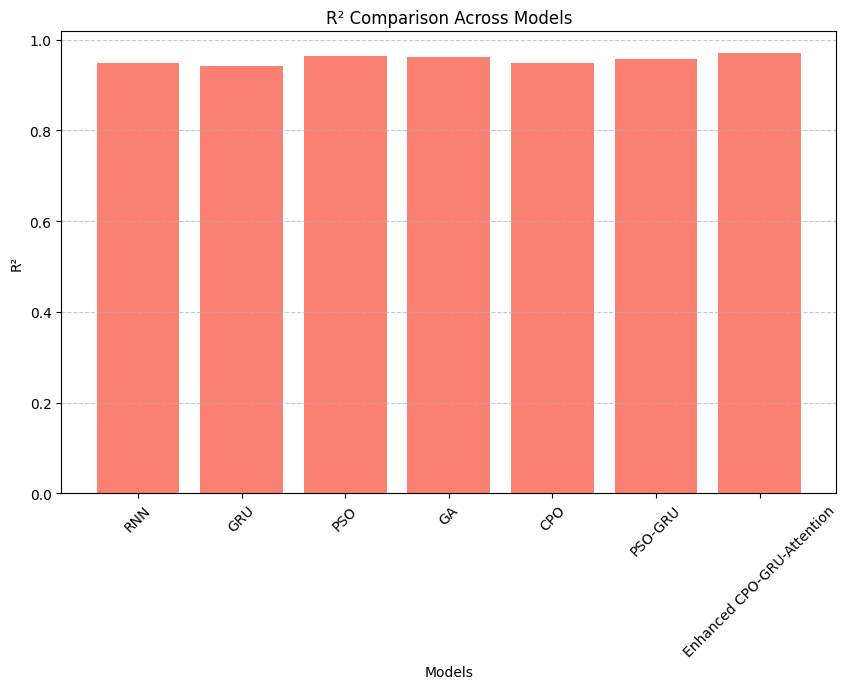

In [15]:
# 2. Bar Charts for Each Metric
models_names = list(results.keys())

# RMSE Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(models_names, [results[name]['RMSE'] for name in models_names], color='skyblue')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# MAE Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(models_names, [results[name]['MAE'] for name in models_names], color='lightgreen')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAE Comparison Across Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# R2 Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(models_names, [results[name]['R2'] for name in models_names], color='salmon')
plt.xlabel('Models')
plt.ylabel('R²')
plt.title('R² Comparison Across Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

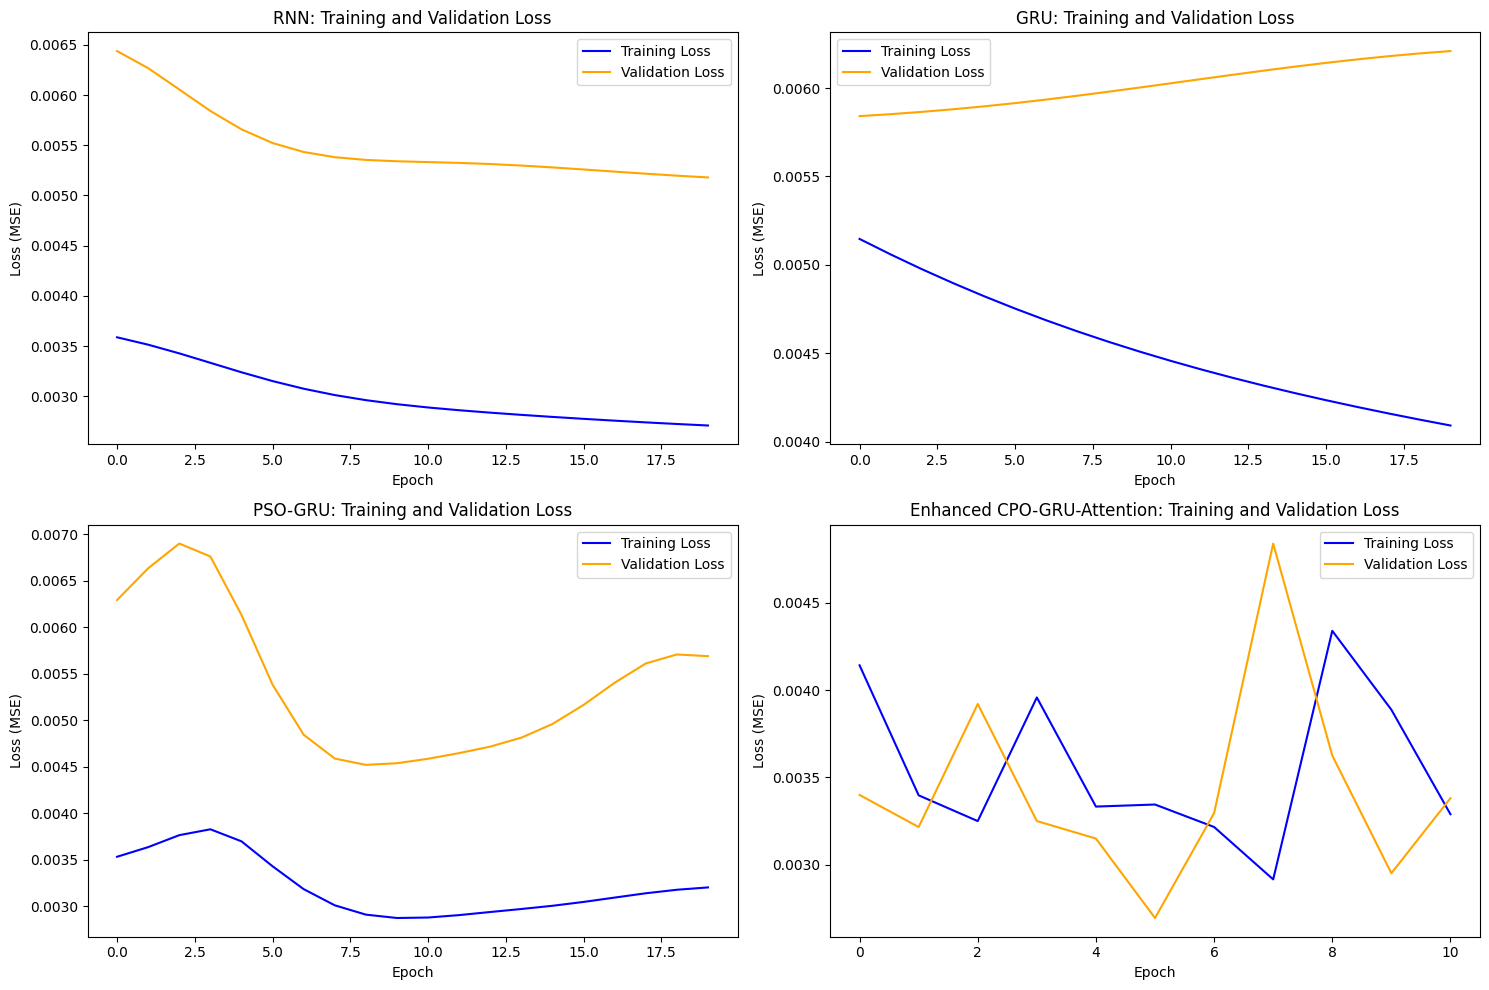

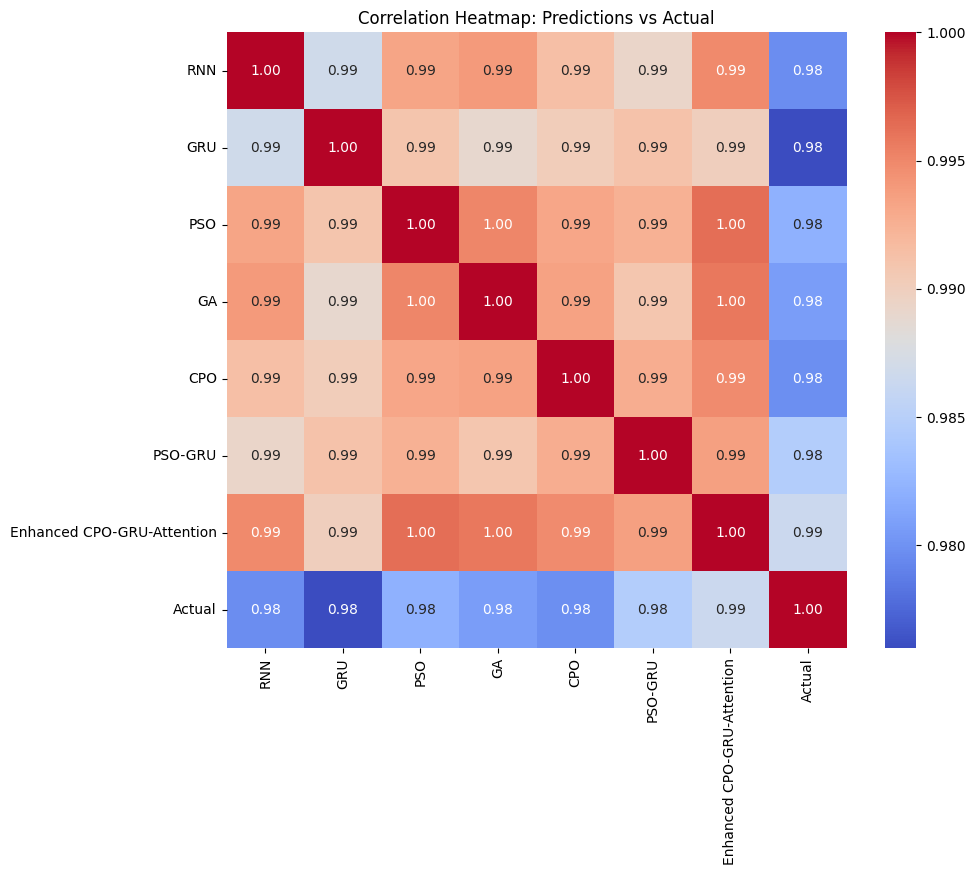


Best performing model based on RMSE: Enhanced CPO-GRU-Attention


In [16]:
# 3. Training and Validation Loss Curves
plt.figure(figsize=(15, 10))
deep_learning_models = ['RNN', 'GRU', 'PSO-GRU', 'Enhanced CPO-GRU-Attention']

for i, name in enumerate(deep_learning_models, 1):
    plt.subplot(2, 2, i)
    model = models[name]
    history = model.fit(X_train, y_train, epochs=20 if name != 'Enhanced CPO-GRU-Attention' else 25,
                        batch_size=32, validation_data=(X_val, y_val), verbose=0,
                        callbacks=[early_stopping] if name == 'Enhanced CPO-GRU-Attention' else None)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{name}: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
plt.tight_layout()
plt.show()

# 4. Correlation Heatmap
predictions = {}
for name, model in models.items():
    if name in ['RNN', 'GRU', 'PSO-GRU', 'Enhanced CPO-GRU-Attention']:
        predictions[name] = model.predict(X_test, verbose=0).flatten()
    else:
        predictions[name] = model.predict(X_test_flat, verbose=0).flatten()
predictions['Actual'] = y_test

correlation_matrix = pd.DataFrame(predictions).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Predictions vs Actual')
plt.show()

# --- Step 11: Conclusion ---
best_model = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest performing model based on RMSE: {best_model}")